To open notebook in Colab please click below:
<a href="https://colab.research.google.com/github/bwolfson2/foster_in_dev/blob/master/Module6_Text_NaiveBayes/mining_text.ipynb" target="_parent"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" /> </a>'

In [2]:
#If opening in colab run this cell
!git clone https://github.com/bwolfson2/foster_in_dev
%cd foster_in_dev/Module6_Text_NaiveBayes

Cloning into 'foster_in_dev'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 961 (delta 91), reused 166 (delta 65), pack-reused 729
Receiving objects: 100% (961/961), 274.46 MiB | 31.01 MiB/s, done.
Resolving deltas: 100% (417/417), done.
/content/foster_in_dev/Module6_Text_NaiveBayes


# Dealing with text and Naive Bayes


Spring 2021 - Instructors: Foster Provost and Ben Wolfson

Teaching Assistant: Ben Wolfson
***

In [3]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pylab as plt
%matplotlib inline

# We will want to keep track of some different roc curves, lets do that here
tprs = []
fprs = []
roc_labels = []
aucs = []

## Document classification and customer satisfaction

You've been hired by Trans American Airlines (TAA) as a business analytics professional. One of the top priorities of TAA is  customer service. For TAA, it is of utmost importance to identify whenever customers are unhappy with the way employees have treated them. You've been hired to analyze twitter data in order to detect whenever a customer has complaints about flight attendants. Tweets suspected to be related to flight attendant complaints should be forwarded directly to the customer service department in order to track the issue and take corrective actions.  

Let's start by loading the data.

In [4]:
data_path = 'data/tweets.csv'
df = pd.read_csv(data_path)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,name,retweet_count,text,tweet_created,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,cairdin,0,@TAA What @dhepburn said.,2/24/2015 11:35,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,jnardino,0,@TAA plus you've added commercials to the expe...,2/24/2015 11:15,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,yvonnalynn,0,@TAA I didn't today... Must mean I need to tak...,2/24/2015 11:15,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,jnardino,0,@TAA it's really aggressive to blast obnoxious...,2/24/2015 11:15,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,jnardino,0,@TAA and it's a really big bad thing about it,2/24/2015 11:14,Pacific Time (US & Canada)


Let's take a look at what do people complain about in Twitter.

In [5]:
df.shape


(14640, 10)

In [6]:
df.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

We will define our target variable based on "Flight Attendant Complaints"

In [7]:
# We'll call our target variable "is_fa_complaint" and keep only the text as a "feature" (really, the field from which we will engineer features)
df["is_fa_complaint"] = (df.negativereason == "Flight Attendant Complaints").astype(int)
df = df[["is_fa_complaint", "text"]]
df.shape

(14640, 2)

Let's take a look at the percentage of tweets related to complaints about flight attendants.

In [8]:
df['is_fa_complaint'].mean()

0.032855191256830604

Here are some examples of the tweets.

In [9]:
print("Flagged as FA complaints:")
print(df[df.is_fa_complaint == 1].text.values[0:5])

print("\nNot flagged as FA complaint:")
print(df[df.is_fa_complaint == 0].text.values[0:5])

Flagged as FA complaints:
['@TAA your airline is awesome but your lax loft needs to step up its game. $40 for dirty tables and floors? http://t.co/hy0VrfhjHt'
 "@TAA You'd think paying an extra $100 bucks RT for luggage might afford you hiring an extra hand at @sfo #lame"
 '@TAA  for all my flight stuff wrong and did nothing about it. Had #worst #flight ever'
 '@TAA husband and I ordered three drinks via my screen and they never came. Awesome!'
 '@TAA All of group E was told there was no more room in the bins. when I got on the plane, was room for at least 4 bags in my row!']

Not flagged as FA complaint:
['@TAA What @dhepburn said.'
 "@TAA plus you've added commercials to the experience... tacky."
 "@TAA I didn't today... Must mean I need to take another trip!"
 '@TAA it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'
 "@TAA and it's a really big bad thing about it"]


Since we are going to do some predictive modeling, we should split our data into a training and a test set.

In [10]:
X = df['text']
Y = df['is_fa_complaint']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=42)

### Text to features
How can we turn the large amount of text for each record into useful features?


#### Binary representation
One way is to create a matrix that uses each word as a feature and keeps track of whether or not a word appears in a document/record. You can do this in sklearn with a `CountVectorizer()` and setting `binary` to `true`. The process is very similar to how you fit a model: you will fit a `CounterVectorizer()`. This will figure out what words exist in your data.

In [11]:
binary_vectorizer = CountVectorizer(binary=True)
binary_vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Let's look at the vocabulary the `CountVectorizer()` learned.

In [12]:
vocabulary_list = list(zip( binary_vectorizer.vocabulary_.keys(), binary_vectorizer.vocabulary_.values()) )

vocabulary_list[0:10]

[('taa', 11423),
 ('you', 13183),
 ('are', 2113),
 ('offering', 8578),
 ('us', 12427),
 ('rooms', 10179),
 ('for', 5391),
 ('32', 674),
 ('people', 8994),
 ('fail', 5021)]

Now that we know what words are in the data, we can transform our text into a clean matrix. Simply .transform() the raw data using our fitted CountVectorizer(). You will do this for the training and test data. What do you think happens if there are new words in the test data that were not seen in the training data?

In [13]:
X_train_binary = binary_vectorizer.transform(X_train)
X_test_binary = binary_vectorizer.transform(X_test)

We can take a look at our new `X_test_binary`.

In [14]:
X_test_binary

<2928x13271 sparse matrix of type '<class 'numpy.int64'>'
	with 45588 stored elements in Compressed Sparse Row format>

In [15]:
X_test_binary.shape

(2928, 13271)

Sparse matrix? Where is our data?

If you look at the output above, you will see that it is being stored in a *sparse* matrix (as opposed to the typical dense matrix) that is 3k rows long and 13k columns. The rows here are records in the original data and the columns are words. Given the shape, this means there are 39m cells that should have values. However, from the above, we can see that only 46k cells (~0.12%) of the cells have values! Why is this?

To save space, sklearn uses a sparse matrix. This means that only values that are not zero are stored. This saves a ton of space! This also means that visualizing the data is a little trickier. Let's look at a very small chunk.

In [16]:
# Recall that 13183 is the index for "you"
X_test_binary[0:20, 13180:13200].todense()

matrix([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0,

#### Applying a model
Now that we have a ton of features (one for every word!) let's try using a logistic regression model to predict which tweets are about flight attendant complaints.

AUC for binary = 0.834


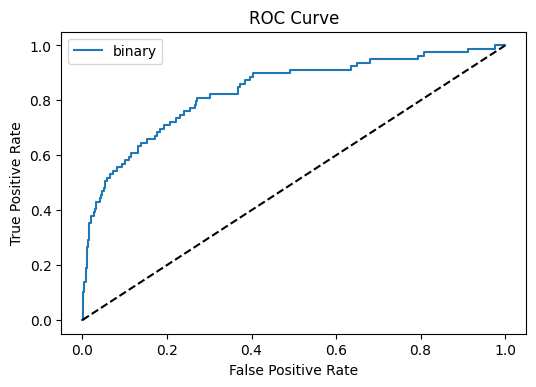

In [17]:
def get_model_roc(models, Xs_test, names, Y_test):
    plt.rcParams['figure.dpi'] = 100
    for i in range(len(models)):
        model = models[i]
        X_test = Xs_test[i]
        name = names[i]
        probs = model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(Y_test, probs)
        plt.plot(fpr, tpr, label=name)
        plt.plot([0, 1], [0, 1], linestyle='dashed', color='black')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        print ("AUC for {0} = {1:.3f}".format(name, metrics.roc_auc_score(Y_test, probs)))
    plt.legend()
    plt.show()

        
model_binary = LogisticRegression(solver='liblinear')
model_binary.fit(X_train_binary, Y_train)
get_model_roc([model_binary], [X_test_binary], ['binary'], Y_test)

#### Counts instead of binary
Instead of using a 0 or 1 to represent the occurence of a word, we can use the actual counts. We do this the same way as before, but now we leave `binary` set to `false` (the default value).

AUC for binary = 0.834
AUC for counts = 0.831


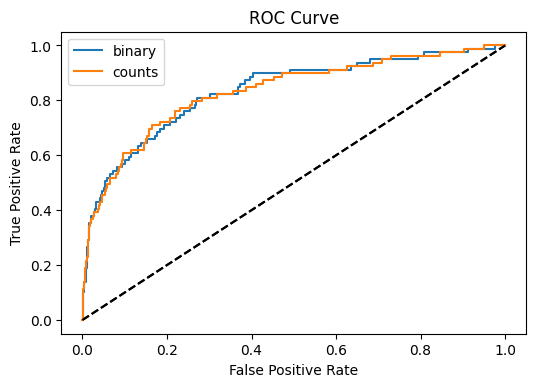

In [18]:
# Fit a counter
count_vectorizer = CountVectorizer()
count_vectorizer.fit(X_train)

# Transform to counter
X_train_counts = count_vectorizer.transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

# Model
model_counts = LogisticRegression(solver='liblinear')
model_counts.fit(X_train_counts, Y_train)

get_model_roc([model_binary, model_counts], [X_test_binary, X_test_counts], ['binary', 'counts'], Y_test)

#### Tf-idf
Another popular technique when dealing with text is to use the term frequency - inverse document frequency (tf-idf) measure instead of just counts as the feature values (see the book).

AUC for binary = 0.834
AUC for tf-idf = 0.856


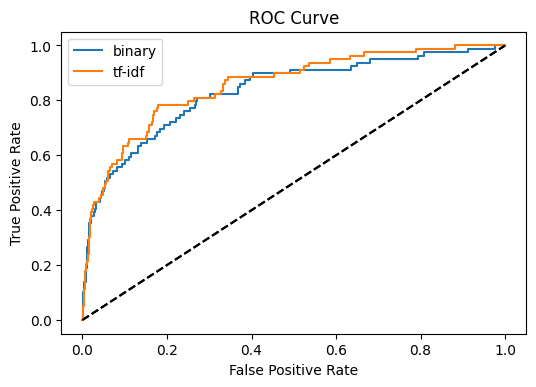

In [19]:
# Fit a counter
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)

# Transform to a counter
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Model
model_tfidf = LogisticRegression(solver='liblinear')
model_tfidf.fit(X_train_tfidf, Y_train)

get_model_roc([model_binary, model_tfidf], [X_test_binary, X_test_tfidf], ['binary', 'tf-idf'], Y_test)

The `CountVectorizer()` and `TfidfVectorizer()` functions have many options. You can restrict the words you would like in the vocabulary. You can add n-grams. You can use stop word lists. Which options you should use generally depend on the type of data you are dealing with. 

AUC for binary = 0.834
AUC for 2-ngram = 0.863


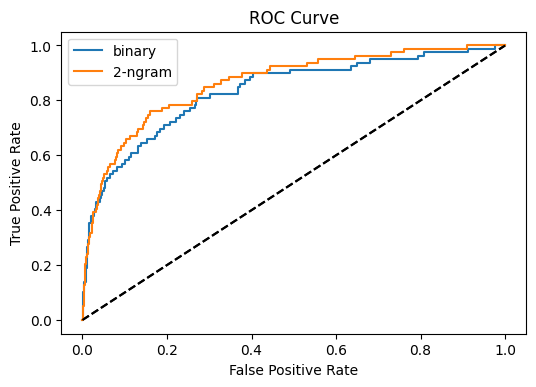

In [20]:
# Fit a counter
ngram_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
ngram_vectorizer.fit(X_train)

# Transform to a counter
X_train_ngram = ngram_vectorizer.transform(X_train)
X_test_ngram = ngram_vectorizer.transform(X_test)

# Model
model_ngram = LogisticRegression(solver='liblinear')
model_ngram.fit(X_train_ngram, Y_train)

get_model_roc([model_binary, model_ngram], [X_test_binary, X_test_ngram], ['binary', '2-ngram'], Y_test)

### Modeling with another technique: Naive Bayes

So far we have been exposed to tree classifiers and logistic regression in class. Now, it's time for another popular modeling technique of supervised learning (especially in text classification): the Naive Bayes (NB) classifier. In particular, we are using a Bernoulli Naive Bayes (BNB) for our binary classification. (Bernoulli NB is the model described in the book; there are other versions of NB -- see below.)

As described in your text, the Naive Bayes model is a **probabilistic approach which assumes conditional independence between features** (in this case, each word/ngram is a feature, the conditioning is on the true class). It assigns class labels (e.g. is_fa_complaint = 1 or is_fa_complaint = 0). In other words, Naive Bayes models the probabilities of the presence of each _word_, given that we have a flight attendant complaint, and given that we do not have a flight attendant complaint.  Then it combines them using Bayes Theorem (again, as described in the book).

Using this model in sklearn works just the same as the others we've seen ([More details here..](http://scikit-learn.org/stable/modules/naive_bayes.html))

- Choose the model
- Fit the model (Train)
- Predict with the model (Train or Test or Use data)

In [21]:
from sklearn.naive_bayes import BernoulliNB

model_nb = BernoulliNB()
model_nb.fit(X_train_binary, Y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

AUC for binary = 0.834
AUC for naive-bayes = 0.802


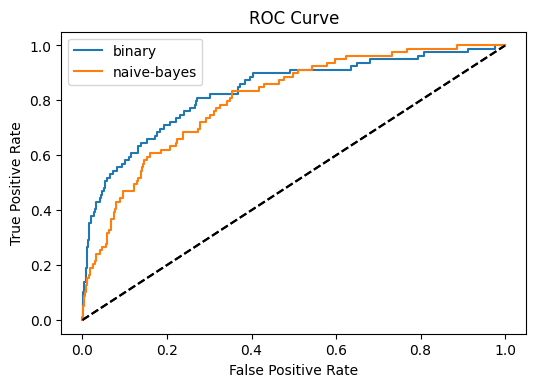

In [22]:
get_model_roc([model_binary, model_nb], [X_test_binary, X_test_binary], ['binary', 'naive-bayes'], Y_test)

The past few weeks we have seen that many of the models we are using have different complexity control parameters that can be tweaked. In naive Bayes, the parameter that is typically tuned is the Laplace smoothing value **`alpha`**.

Also, there are other versions of naive Bayes:

1. **Multinomial naive Bayes (MNB):** This model handles count features and not just binary features. Sometimes MNB is used with binary presence/absence variables anyway (like word presence), even though that violates the model assumptions, because in practice it works well anyway.
2. **Gaussian Naive Bayes (GNB):** This model considers likelihood of the features as Gaussian--and thus we can use it for continuous features.  Sometimes GNB and Bernoulli NB are combined when one has features of mixed types.  

You can try out all of these alternatives!